In [52]:
import click
import glob
import logging
import os
import tarfile


from geocovid.constants import DATA_DIR, TMP_DIR
from geocovid.data_pipeline import extract_data_spark, transform_data_spark
from geocovid.model import GeoCovidModel
from geocovid.utils import start_spark

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")

INFO:root:test


In [ ]:
files = glob.glob(os.path.join(DATA_DIR, "*.tar.gz"))
sorted_files = sorted(files)
print(sorted_files[-1])
fname = '/Users/awolfmann/Documents/data_eng_challenge/grandata-challenge/geocovid/data/iso_date=2020-06-21.tar.gz'

with tarfile.open(fname, "r:gz") as tfile:
    path = os.path.join(TMP_DIR, os.path.basename(fname).split(".")[0])
    #try:
    tfile.extractall(path=path, members=tfile)
    logger.info("dirname %s", path)
    #except:
    #    logger.info("FAILED dirname %s", path)
    tfile.close()

In [14]:
#spark = start_spark()
sdf = extract_data_spark(TMP_DIR, spark)

In [15]:
sdf.show(10)

+--------------------+----------+----------+----------+------------+----------+
|                  id| timestamp|  latitude| longitude|  geohash_12|  iso_date|
+--------------------+----------+----------+----------+------------+----------+
|F50B8A545392ABFF4...|1592456953|-34.841015|   -55.989|6cb1vcqh3u45|2020-06-18|
|F9334BAD08B17DC9F...|1592519793|-34.915546|-56.169582|6cb13gfd1ykc|2020-06-18|
|BC0FDB9F2BEA2140F...|1592481848| -34.75533| -56.01496|6cb4m2gpsbfs|2020-06-18|
|394DDABB5244132B4...|1592457048| -33.12643| -58.31124|6dne91e09d59|2020-06-18|
|093A2CBDCC1F0D16A...|1592518731| -34.71241|-55.956306|6cb4w8vce9fq|2020-06-18|
|056F5AF6AEDC28A87...|1592505926|-34.651134|-56.588478|69zfb7cw8bk7|2020-06-18|
|49C56ABAD402DE3B6...|1592446707|-34.813244| -56.22547|6cb1bw3y5t4u|2020-06-18|
|DC27F4E50AE37C401...|1592482385|-31.346367|-57.859383|6dqvems44tt6|2020-06-18|
|859EE2C24A5CAFB35...|1592493144|-34.906605|-56.154625|6cb16jmqq2vn|2020-06-18|
|9D138D3A857CE4CE3...|1592454620| -34.92

In [16]:
sdf.select('id').distinct().count()

33647

In [17]:
sdf.createOrReplaceTempView("points")

In [18]:
spark.sql("select distinct(count(id)) from points").show()

+---------+
|count(id)|
+---------+
| 41226296|
+---------+



In [19]:
point_df = spark.sql(
        """
        SELECT points.id, hour(cast(points.timestamp AS timestamp)) AS h,
                ST_Envelope_Aggr(ST_Point(cast(points.latitude AS Decimal(24,20)),
                                          cast(points.longitude AS Decimal(24,20)))) 
                AS geometry
        FROM points group by h, id
        """
    )

In [20]:
point_df.createOrReplaceTempView("points_agg")

In [21]:
area_df = spark.sql(
    """
    SELECT id, h, ST_Area(points_agg.geometry) as area
    FROM points_agg
    """
)

In [31]:
area_df.createOrReplaceTempView("area_agg")

In [24]:
area_df.describe('area').show()

+-------+------------------+
|summary|              area|
+-------+------------------+
|  count|            584223|
|   mean|1.0858138679404765|
| stddev| 44.26251853277789|
|    min|               0.0|
|    max| 8057.251752344568|
+-------+------------------+



In [27]:
area_df.approxQuantile("area", [0.5], 0.25)

[1.757199999985329e-08]

In [39]:
import pyspark.sql.functions as func

In [42]:
parea_df = area_df.toPandas()

In [50]:
for g, df in parea_df.groupby('h'):
    print(g)
    print('{:.20f}'.format(df.area.median()))
    print('{:.20f}'.format(df.id.nunique()))

0
0.00000045529500000081
24536.00000000000000000000
1
0.00000014826050000209
24032.00000000000000000000
2
0.00000007761199999960
23424.00000000000000000000
3
0.00000005743050000012
23084.00000000000000000000
4
0.00000004678699999925
22678.00000000000000000000
5
0.00000005580000000100
22523.00000000000000000000
6
0.00000009976000000147
22769.00000000000000000000
7
0.00000091062900000236
23201.00000000000000000000
8
0.00001448755200001102
23733.00000000000000000000
9
0.00006267236700005315
24136.00000000000000000000
10
0.00013973513000002208
24497.00000000000000000000
11
0.00022934940000009110
24707.00000000000000000000
12
0.00026734985500008284
24965.00000000000000000000
13
0.00029252451799998514
25023.00000000000000000000
14
0.00034699842600005896
25028.00000000000000000000
15
0.00041569560999996617
25111.00000000000000000000
16
0.00045578405400007274
25149.00000000000000000000
17
0.00042327583499995175
25152.00000000000000000000
18
0.00024910070899994554
25133.00000000000000000000
19


## la gente no se mueve entre las 22 y las 7am -> mejorar computo unificando esa franja horaria.
## momento de mayor pico de movimiento 15-18hs

In [48]:
parea_df.shape

(584223, 3)

In [49]:
parea_df.id.nunique()

33647

In [ ]:
    clean_df = spark.sql(
        """
        SELECT id, h,
            CASE WHEN ST_Area(points_agg.geometry) < 0.0001
            THEN points_agg.geometry
            ELSE ST_Centroid(points_agg.geometry)
            END as geometry
        FROM points_agg
        """
    )

In [71]:
import pandas as pd

In [72]:
a_df = pd.read_json('results_agents.json')

In [73]:
a_df.head()

,status,lat,lon
"(1, '022BFF62CB705BCFF0A60D8E16113FD20A6CBBBF')",0,-33.233050,-54.374035
"(1, '03481ADB47899B0C62450CB6BB502A4D70029D59')",0,-34.372265,-55.219536
"(1, '06817CFE95AAF72AB45876F7622504EA7FA5B583')",0,-34.868237,-56.131813
"(1, '0C0CD11D8B6A3C906F2BD35DACC8B315D9408015')",0,-34.875849,-56.106203
"(1, '127B418773A90ED7399B6EE72870354294E79664')",0,-34.865340,-56.056140


In [88]:
a_dfa = zip(*a_df[:10].reset_index()['index'])


In [89]:
a

In [74]:
pd.MultiIndex.from_tuples(a_df.index, names=('h', 'id'))

TypeError: Expected tuple, got str

In [97]:
m_df = pd.read_json('results_model.json')

In [98]:
m_df.head()

,S,I,R,D,IS,A,NA
0,11969,103,0,0,3,12072,12072
1,12596,104,0,0,1,12700,12700
2,12895,104,0,0,0,12999,12999
3,13118,107,0,0,3,13225,13225
4,13227,107,0,0,0,13334,13334


<AxesSubplot:>

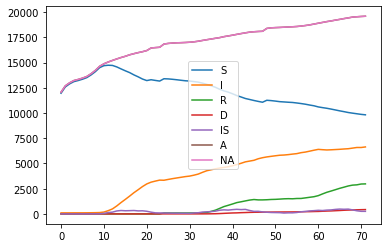

In [100]:
m_df.plot()